In [25]:
import glob
import os
import omegaconf

import pandas as pd
import numpy as np
import random

import logging

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneGroupOut

import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns


logging.basicConfig()
logging.getLogger().setLevel(logging.INFO)


In [26]:
path_champollion = "/neurospin/dico/data/deep_folding/current/models/Champollion_V0_trained_on_UKB40"
participants_file = "/neurospin/dico/data/deep_folding/current/datasets/UkBioBank/participants.csv"
embeddings_subpath = "ukb40_random_epoch80_embeddings/full_embeddings.csv"
output_filename = f"{path_champollion}/summary/Sex_ukb_without_residualization.csv"
label = "Sex"
max_iter = 2000
cv = 3

In [27]:
participants = pd.read_csv(participants_file, index_col=0)


In [28]:
# participants[participants.Sex==0]["BrainVolumeFreeSurfer_mm3"].hist(bins=100)

In [29]:
# participants[participants.Sex==1]["BrainVolumeFreeSurfer_mm3"].hist(bins=100)

In [30]:
participants = participants[[label]].dropna()

array([[<Axes: title={'center': 'Sex'}>]], dtype=object)

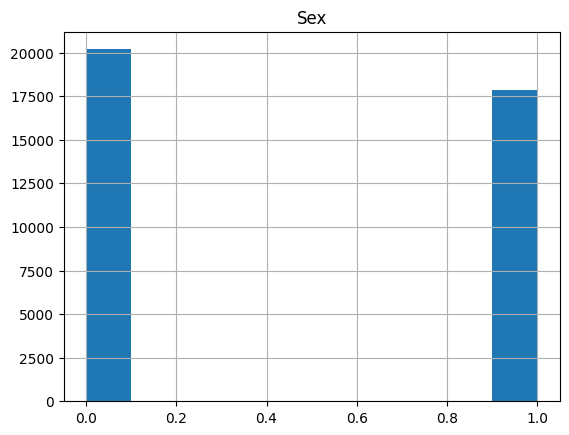

In [31]:
participants.hist()

In [32]:
def is_it_a_file(sub_dir):
    if os.path.isdir(sub_dir):
        return False
    else:
        logging.debug(f"{sub_dir} is a file. Continue.")
        return True
    

def is_folder_a_model(sub_dir):
    if os.path.exists(sub_dir+'/.hydra/config.yaml'):
        return True
    else:
        logging.debug(f"\n{sub_dir} not associated to a model. Continue")
        return False

def get_model_paths(dir_path, result = None):
    """Recursively gets all models included in dir_path"""
    if result is None:  # create a new result if no intermediate was given
        result = [] 
    for name in os.listdir(dir_path):
        sub_dir = dir_path + '/' + name
        # checks if directory
        if is_it_a_file(sub_dir):
            pass
        elif not is_folder_a_model(sub_dir):
            result.extend(get_model_paths(sub_dir))
        else:
            result.append(sub_dir)
    return result

In [33]:
model_paths = get_model_paths(path_champollion)

In [34]:
model_paths[:5]

['/neurospin/dico/data/deep_folding/current/models/Champollion_V0_trained_on_UKB40/SC-sylv_left/11-42-04_96_0',
 '/neurospin/dico/data/deep_folding/current/models/Champollion_V0_trained_on_UKB40/SFinter-SFsup_left/20-35-42_194_0',
 '/neurospin/dico/data/deep_folding/current/models/Champollion_V0_trained_on_UKB40/STi-STs-STpol_right/13-58-38_123_0',
 '/neurospin/dico/data/deep_folding/current/models/Champollion_V0_trained_on_UKB40/FColl-SRh_right/11-53-20_181_0',
 '/neurospin/dico/data/deep_folding/current/models/Champollion_V0_trained_on_UKB40/SC-sylv_right/11-36-10_85_0']

In [38]:
def compute(model_path):
    # Gets region name
    cfg = omegaconf.OmegaConf.load(model_path+'/.hydra/config.yaml')
    region = cfg['dataset'][next(iter(cfg['dataset']))]['crop_dir'].split('/')[-3]
    side = next(iter(cfg['dataset'])).split('_')[-1]
    region = region + '_' + side
    model_name = model_path.split('/')[-1]
    region_path = '/'.join(model_path.split('/')[-2:])
    print(f"Treating {region}: {region_path} : {model_path}")
    
    # Loads embeddings
    embeddings = pd.read_csv(f"{model_path}/{embeddings_subpath}", index_col=0)
    merged = participants[[label]].merge(embeddings, left_index=True, right_index=True)
    
    # Classifies
    X = merged.drop([label], axis=1)
    Y = merged[[label]]
    scaler = StandardScaler()
    X[X.columns] = scaler.fit_transform(X)
    df2 = X.copy()

    # Makes OLS
    df2 = sm.add_constant(df2)
    model = sm.OLS(Y[label], df2)
    results = model.fit()
    f_value = results.fvalue
    p_value = results.f_pvalue
    
    # Gets result
    # roc_auc = roc_auc_score(Y, proba_pred[:,1])
    print(f_value)
    
    # Returns result
    return (region, f_value, p_value, model_name, region_path, model_path)

In [39]:
result = []
for model_path in model_paths:
    result.append(compute(model_path))

Treating S.C.-sylv._left: SC-sylv_left/11-42-04_96_0 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0_trained_on_UKB40/SC-sylv_left/11-42-04_96_0
31.65392547923908
Treating S.F.inter.-S.F.sup._left: SFinter-SFsup_left/20-35-42_194_0 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0_trained_on_UKB40/SFinter-SFsup_left/20-35-42_194_0
21.73699479443948
Treating S.T.i.-S.T.s.-S.T.pol._right: STi-STs-STpol_right/13-58-38_123_0 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0_trained_on_UKB40/STi-STs-STpol_right/13-58-38_123_0
33.37212314320652
Treating F.Coll.-S.Rh._right: FColl-SRh_right/11-53-20_181_0 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0_trained_on_UKB40/FColl-SRh_right/11-53-20_181_0
71.43212997581404
Treating S.C.-sylv._right: SC-sylv_right/11-36-10_85_0 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0_trained_on_UKB40/SC-sylv_right/11-36-10_85_0
30.951822010790988
Treating Lobule_parietal_su

In [40]:
df = pd.DataFrame(result, columns=['region', 'f_value', 'p_value', 'model_name', 'region_path', 'model_path'])

In [41]:
df

,region,f_value,p_value,model_name,region_path,model_path
0,S.C.-sylv._left,31.653925,0.0,11-42-04_96_0,SC-sylv_left/11-42-04_96_0,/neurospin/dico/data/deep_folding/current/mode...
1,S.F.inter.-S.F.sup._left,21.736995,0.0,20-35-42_194_0,SFinter-SFsup_left/20-35-42_194_0,/neurospin/dico/data/deep_folding/current/mode...
2,S.T.i.-S.T.s.-S.T.pol._right,33.372123,0.0,13-58-38_123_0,STi-STs-STpol_right/13-58-38_123_0,/neurospin/dico/data/deep_folding/current/mode...
3,F.Coll.-S.Rh._right,71.432130,0.0,11-53-20_181_0,FColl-SRh_right/11-53-20_181_0,/neurospin/dico/data/deep_folding/current/mode...
4,S.C.-sylv._right,30.951822,0.0,11-36-10_85_0,SC-sylv_right/11-36-10_85_0,/neurospin/dico/data/deep_folding/current/mode...
5,Lobule_parietal_sup._left,37.598481,0.0,17-03-38_155_0,Lobule_parietal_sup_left/17-03-38_155_0,/neurospin/dico/data/deep_folding/current/mode...
6,S.F.int.-S.R._left,30.748162,0.0,19-00-08_34_0,SFint-SR_left/19-00-08_34_0,/neurospin/dico/data/deep_folding/current/mode...
7,S.Po.C._left,27.197040,0.0,19-08-58_16_0,SPoC_left/19-08-58_16_0,/neurospin/dico/data/deep_folding/current/mode...
8,S.F.inf.-BROCA-S.Pe.C.inf._right,20.278094,0.0,13-18-55_195_0,SFinf-BROCA-SPeCinf_right/13-18-55_195_0,/neurospin/dico/data/deep_folding/current/mode...
9,S.s.P.-S.Pa.int._left,33.537235,0.0,16-56-37_137_0,SsP-SPaint_left/16-56-37_137_0,/neurospin/dico/data/deep_folding/current/mode...


In [42]:
df['side'] = df['region'].str.split('_').str[-1]

In [43]:
def plot_horizontal(res, region_name, ax, f_value, p_value, f2_value, visible, title):
    labelsize=10
    ax.xaxis.set_tick_params(labelsize = labelsize)
    ax.yaxis.set_tick_params(labelsize = labelsize)
    
    res = res.sort_values(by=f_value, ascending=True)

    # ax.errorbar(res[AUC_name], res[region_name], res[std_auc_name], fmt='s', color='black')
    # ax.scatter(res[AUC_name], res[region_name], marker='s', color='black')
    ax.axvline(x=0.05, color='black', linestyle='-')
    ax.barh(res[region_name], res[f2_value], fill=True, color='lightgray')
    ax.errorbar(res[f_value], res[region_name], xerr=0, fmt='s', color='black')
    # if visible:
    #     ax.set_ylabel("AUC ensemble")
    # else:
    #     ax.get_yaxis().set_ticks([])
    # ax.set_xlim((0.3, 1.0))
    ax.set_title(title)


In [44]:
df.sort_values(by="f_value", ascending=False)

,region,f_value,p_value,model_name,region_path,model_path,side
3,F.Coll.-S.Rh._right,71.432130,0.0,11-53-20_181_0,FColl-SRh_right/11-53-20_181_0,/neurospin/dico/data/deep_folding/current/mode...,right
13,F.Coll.-S.Rh._left,64.963161,0.0,11-53-20_94_0,FColl-SRh_left/11-53-20_94_0,/neurospin/dico/data/deep_folding/current/mode...,left
24,Sc.Cal.-S.Li._left,59.335327,0.0,16-53-30_109_0,ScCal-SLi_left/16-53-30_109_0,/neurospin/dico/data/deep_folding/current/mode...,left
26,F.P.O.-S.Cu.-Sc.Cal._left,58.084025,0.0,16-28-23_30_0,FPO-SCu-ScCal_left/16-28-23_30_0,/neurospin/dico/data/deep_folding/current/mode...,left
23,fronto-parietal_medial_face._left,55.345683,0.0,16-35-03_57,fronto-parietal_medial_face_left/16-35-03_57,/neurospin/dico/data/deep_folding/current/mode...,left
16,F.C.L.p.-subsc.-F.C.L.a.-INSULA._right,52.904323,0.0,16-47-59_61_0,FCLp-subsc-FCLa-INSULA_right/16-47-59_61_0,/neurospin/dico/data/deep_folding/current/mode...,right
36,S.T.i.-S.O.T.lat._right,51.759945,0.0,14-07-39_164_0,STi-SOTlat_right/14-07-39_164_0,/neurospin/dico/data/deep_folding/current/mode...,right
50,S.T.i.-S.O.T.lat._left,51.359670,0.0,14-07-11_209_0,STi-SOTlat_left/14-07-11_209_0,/neurospin/dico/data/deep_folding/current/mode...,left
25,F.P.O.-S.Cu.-Sc.Cal._right,48.887844,0.0,16-28-23_85_0,FPO-SCu-ScCal_right/16-28-23_85_0,/neurospin/dico/data/deep_folding/current/mode...,right
33,fronto-parietal_medial_face._right,48.733321,0.0,16-36-34_174,fronto-parietal_medial_face_right/16-36-34_174,/neurospin/dico/data/deep_folding/current/mode...,right


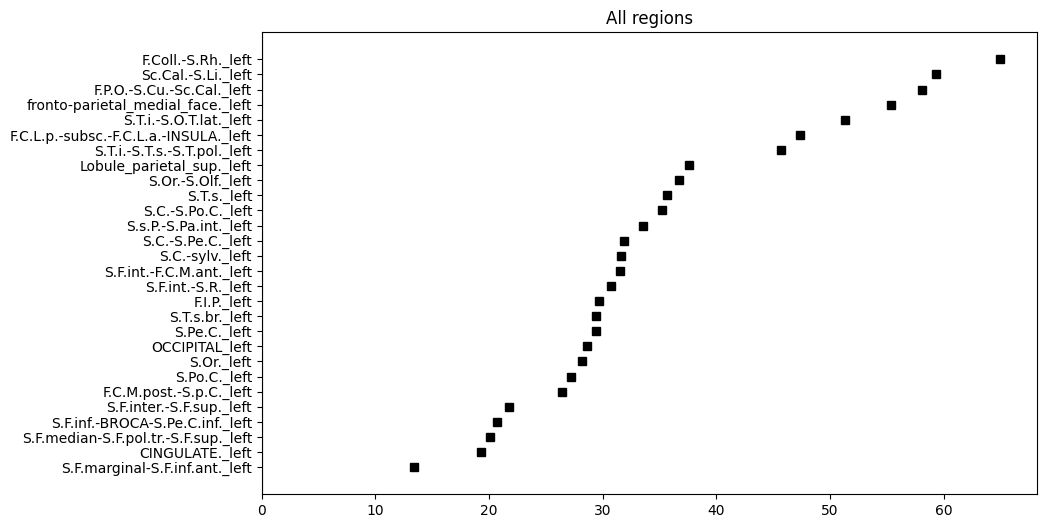

In [45]:
plt.rc('axes', labelsize=12) 
f, ax = plt.subplots(1, 1, figsize=(10, 6))
plot_horizontal(df[df.side=='left'], "region", ax, "f_value", "f_value", "p_value",  True, "All regions")
plt.show()

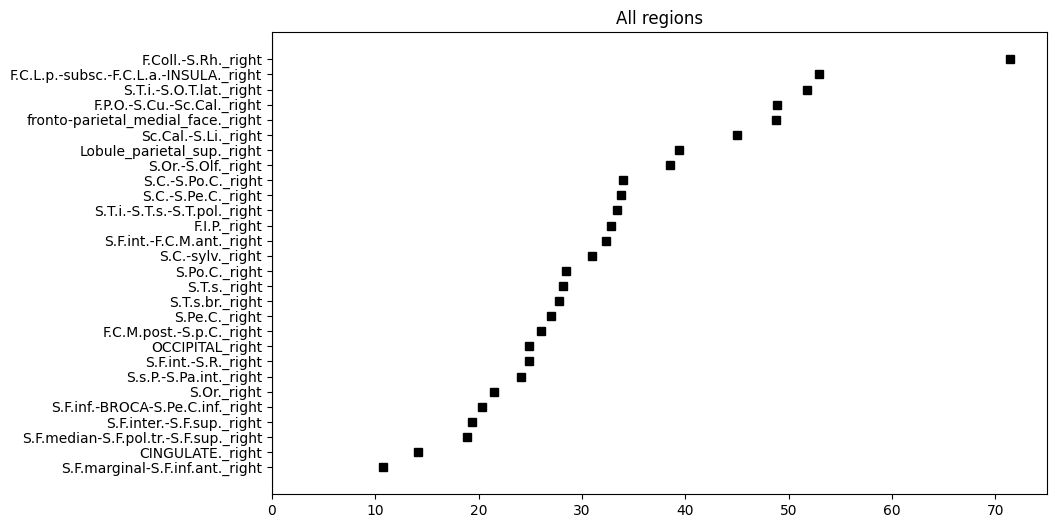

In [46]:
plt.rc('axes', labelsize=12) 
f, ax = plt.subplots(1, 1, figsize=(10, 6))
plot_horizontal(df[df.side=='right'], "region", ax, "f_value", "p_value", "p_value",  True, "All regions")
plt.show()

In [ ]:
df

In [ ]:
# df.to_csv(output_filename)